**MỤC TIÊU**
* Recall > 0.7
* AUC > 0.8
* F1 >0.8

Chú thích về các cột:
Pregnancies: Số lần mang thai của bệnh nhân.

Glucose: Nồng độ glucose trong huyết tương sau khi thực hiện xét nghiệm dung nạp glucose.

BloodPressure: Huyết áp tâm trương (mm Hg).

SkinThickness: Độ dày của da ở vùng cơ tam đầu (mm).

Insulin: Nồng độ insulin trong huyết thanh sau 2 giờ (mu U/ml).

BMI: Chỉ số khối cơ thể (cân nặng tính bằng kg chia cho bình phương chiều cao tính bằng mét).

DiabetesPedigreeFunction: Chức năng phả hệ bệnh tiểu đường, đánh giá khả năng mắc bệnh dựa trên tiền sử gia đình.

Age: Tuổi của bệnh nhân (năm).

Outcome: Biến phân loại (0 hoặc 1) cho biết bệnh nhân có mắc bệnh tiểu đường (1) hay không (0).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV


In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data ML/Final/diabetes.csv')
df.head(5)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [3]:
df.shape

(768, 9)

Tập dữ liệu có 768 dòng, 9 cột
(768, 9)

In [4]:
df.count()

Pregnancies                 768
Glucose                     768
BloodPressure               768
SkinThickness               768
Insulin                     768
BMI                         768
DiabetesPedigreeFunction    768
Age                         768
Outcome                     768
dtype: int64

In [5]:
print(df.dtypes)

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


## Kiểm tra giá trị khuyết thiếu

In [6]:
# Kiểm tra giá trị null trong DataFrame
print(df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


KHÔNG CÓ GIÁ TRỊ NULL

## Giá trị bất thường

In [7]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

Một số biến có giá trị 0 nhưng không hợp lý trong ngữ cảnh:

* Glucose (min = 0): Glucose không thể bằng 0 trong thực tế. Đây có thể là dữ liệu bị thiếu (missing data) được thay bằng 0.
* BloodPressure (min = 0): Huyết áp cũng không thể bằng 0. Đây cũng là trường hợp dữ liệu bị thiếu.
* SkinThickness (min = 0): Độ dày da không thể bằng 0. Đây cũng là giá trị bất hợp lý.
* Insulin (min = 0): Giá trị insulin bằng 0 có thể đại diện cho dữ liệu bị thiếu, vì giá trị này thường có ý nghĩa y tế.

Độ lệch lớn ở một số biến

* Insulin (mean = 79.8, std = 115.24, max = 846): Giá trị insulin có độ lệch chuẩn cao (115.24 so với giá trị trung bình 79.8), cho thấy có thể có nhiều giá trị ngoại lệ (outliers).
* SkinThickness (mean = 20.53, max = 99): Giá trị tối đa (99) có vẻ cao hơn nhiều so với trung bình (20.53), cũng cần kiểm tra outliers.
* BMI (mean = 31.99, max = 67.1): Giá trị tối đa (67.1) cũng khá cao so với trung bình, có thể là ngoại lệ.

Các giá trị phân bố không đều

* Pregnancies: Có thể thấy phân phối này lệch phải vì giá trị tối đa (17) cao hơn nhiều so với trung bình (3.85) và 75% (6). Bạn có thể thử chuẩn hóa biến này hoặc xem xét các nhóm riêng biệt (ví dụ: nhóm có số lần mang thai cao).
* Age: Giá trị tối đa là 81, nhưng 75% giá trị chỉ đến 41, cho thấy phần lớn dữ liệu thuộc nhóm trẻ tuổi.

In [9]:
# Columns to check for zeros
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Count zeros in each column
for col in df.columns:
  zero_count = (df[col] == 0).sum()
  print(f"Số lượng giá trị 0 trong {col}: {zero_count}")

Số lượng giá trị 0 trong Pregnancies: 111
Số lượng giá trị 0 trong Glucose: 5
Số lượng giá trị 0 trong BloodPressure: 35
Số lượng giá trị 0 trong SkinThickness: 227
Số lượng giá trị 0 trong Insulin: 374
Số lượng giá trị 0 trong BMI: 11
Số lượng giá trị 0 trong DiabetesPedigreeFunction: 0
Số lượng giá trị 0 trong Age: 0
Số lượng giá trị 0 trong Outcome: 500


In [10]:
# Danh sách các cột cần xử lý
columns_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Tính toán median cho từng cột, chỉ sử dụng các giá trị khác 0
medians = {}
for column in columns_to_impute:
    # Lọc các giá trị không phải là 0 và tính median
    median_value = df[df[column] != 0][column].median()
    medians[column] = median_value

# Thay thế giá trị 0 trong các cột bằng median
for column in columns_to_impute:
    df[column] = df[column].replace(0, medians[column])

# Kiểm tra kết quả
df.head()


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35      125  33.6   
1            1       85             66             29      125  26.6   
2            8      183             64             29      125  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [12]:
columns_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in columns_to_impute:
  zero_count = (df[col] == 0).sum()
  print(f"Số lượng giá trị 0 trong {col}: {zero_count}")

Số lượng giá trị 0 trong Glucose: 0
Số lượng giá trị 0 trong BloodPressure: 0
Số lượng giá trị 0 trong SkinThickness: 0
Số lượng giá trị 0 trong Insulin: 0
Số lượng giá trị 0 trong BMI: 0


## Kiểm tra các cột có giá trị ngoại lệ

Xử lý ngoại lệ của Insulin, SkinThickness, DiabetesPedigreeFunction

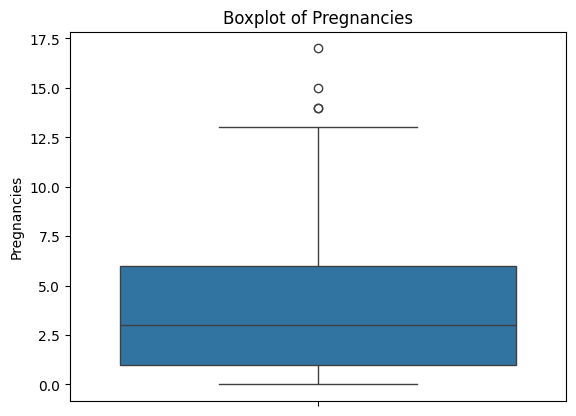

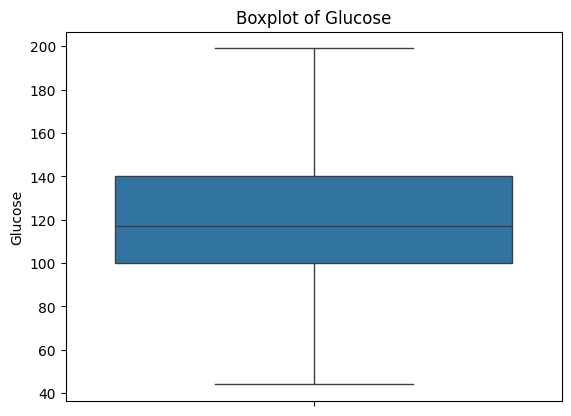

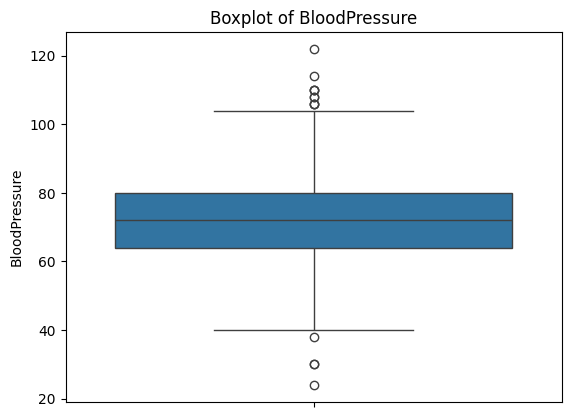

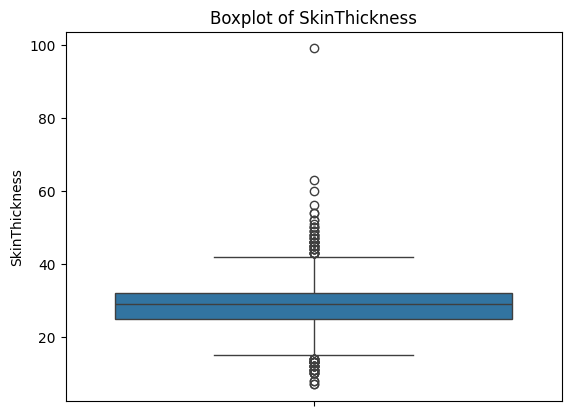

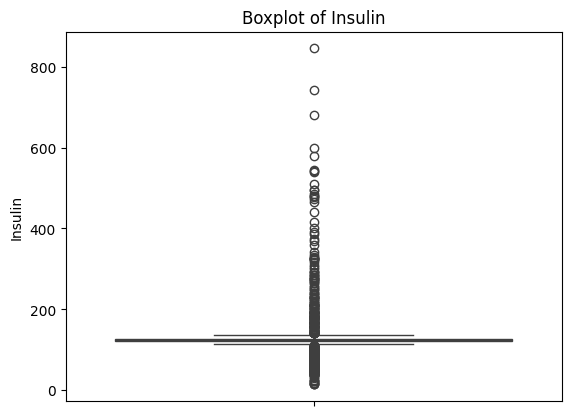

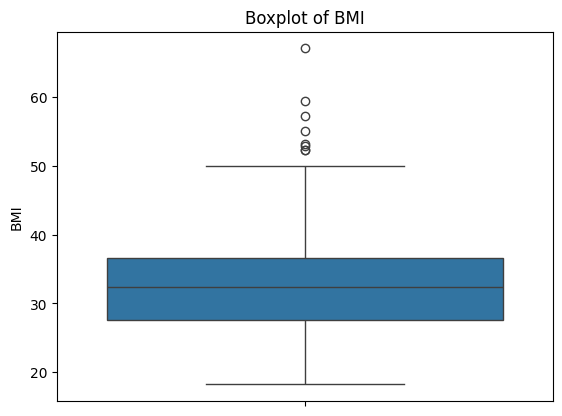

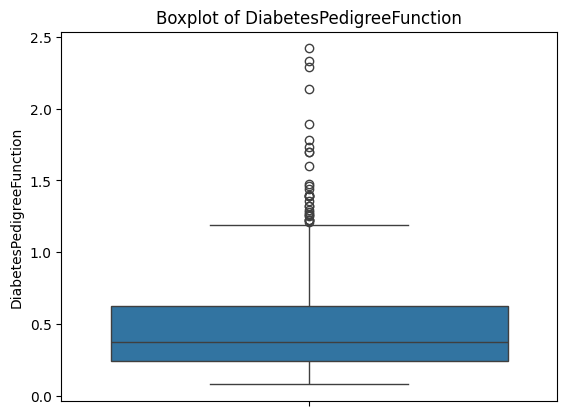

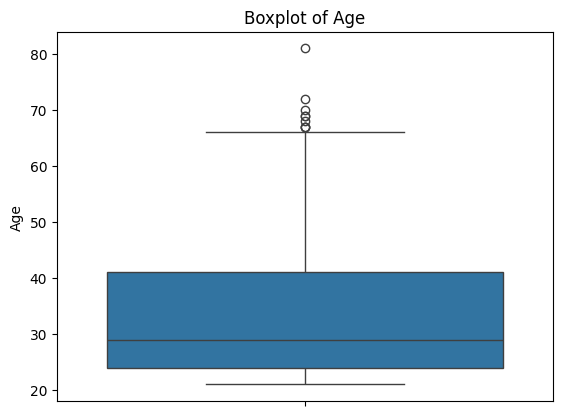

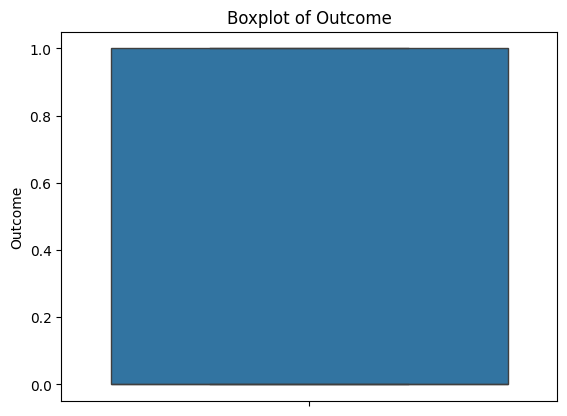

In [13]:
cols = df.columns
for col in cols:
    sns.boxplot(df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [14]:
from scipy import stats
columns_to_check = ['Insulin', 'SkinThickness', 'DiabetesPedigreeFunction']
# Thực hiện kiểm tra Shapiro-Wilk cho độ chuẩn
for col_name in columns_to_check:
    shapiro_test = stats.shapiro(df[col_name])
    print(f"Kiểm tra Shapiro-Wilk cho {col_name}:")
    print(f"  Thống kê: {shapiro_test.statistic}")
    print(f"  Giá trị P: {shapiro_test.pvalue}")
    alpha = 0.05
    if shapiro_test.pvalue > alpha:
        print(f"  Mẫu có vẻ phân phối chuẩn (không bác bỏ H0)")
    else:
        print(f"  Mẫu không có vẻ phân phối chuẩn (bác bỏ H0)")
    print("---")

Kiểm tra Shapiro-Wilk cho Insulin:
  Thống kê: 0.6415107522087105
  Giá trị P: 3.3709011423382152e-37
  Mẫu không có vẻ phân phối chuẩn (bác bỏ H0)
---
Kiểm tra Shapiro-Wilk cho SkinThickness:
  Thống kê: 0.9278423853464557
  Giá trị P: 9.482141291524127e-19
  Mẫu không có vẻ phân phối chuẩn (bác bỏ H0)
---
Kiểm tra Shapiro-Wilk cho DiabetesPedigreeFunction:
  Thống kê: 0.8365181321396535
  Giá trị P: 2.477505530854268e-27
  Mẫu không có vẻ phân phối chuẩn (bác bỏ H0)
---


array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

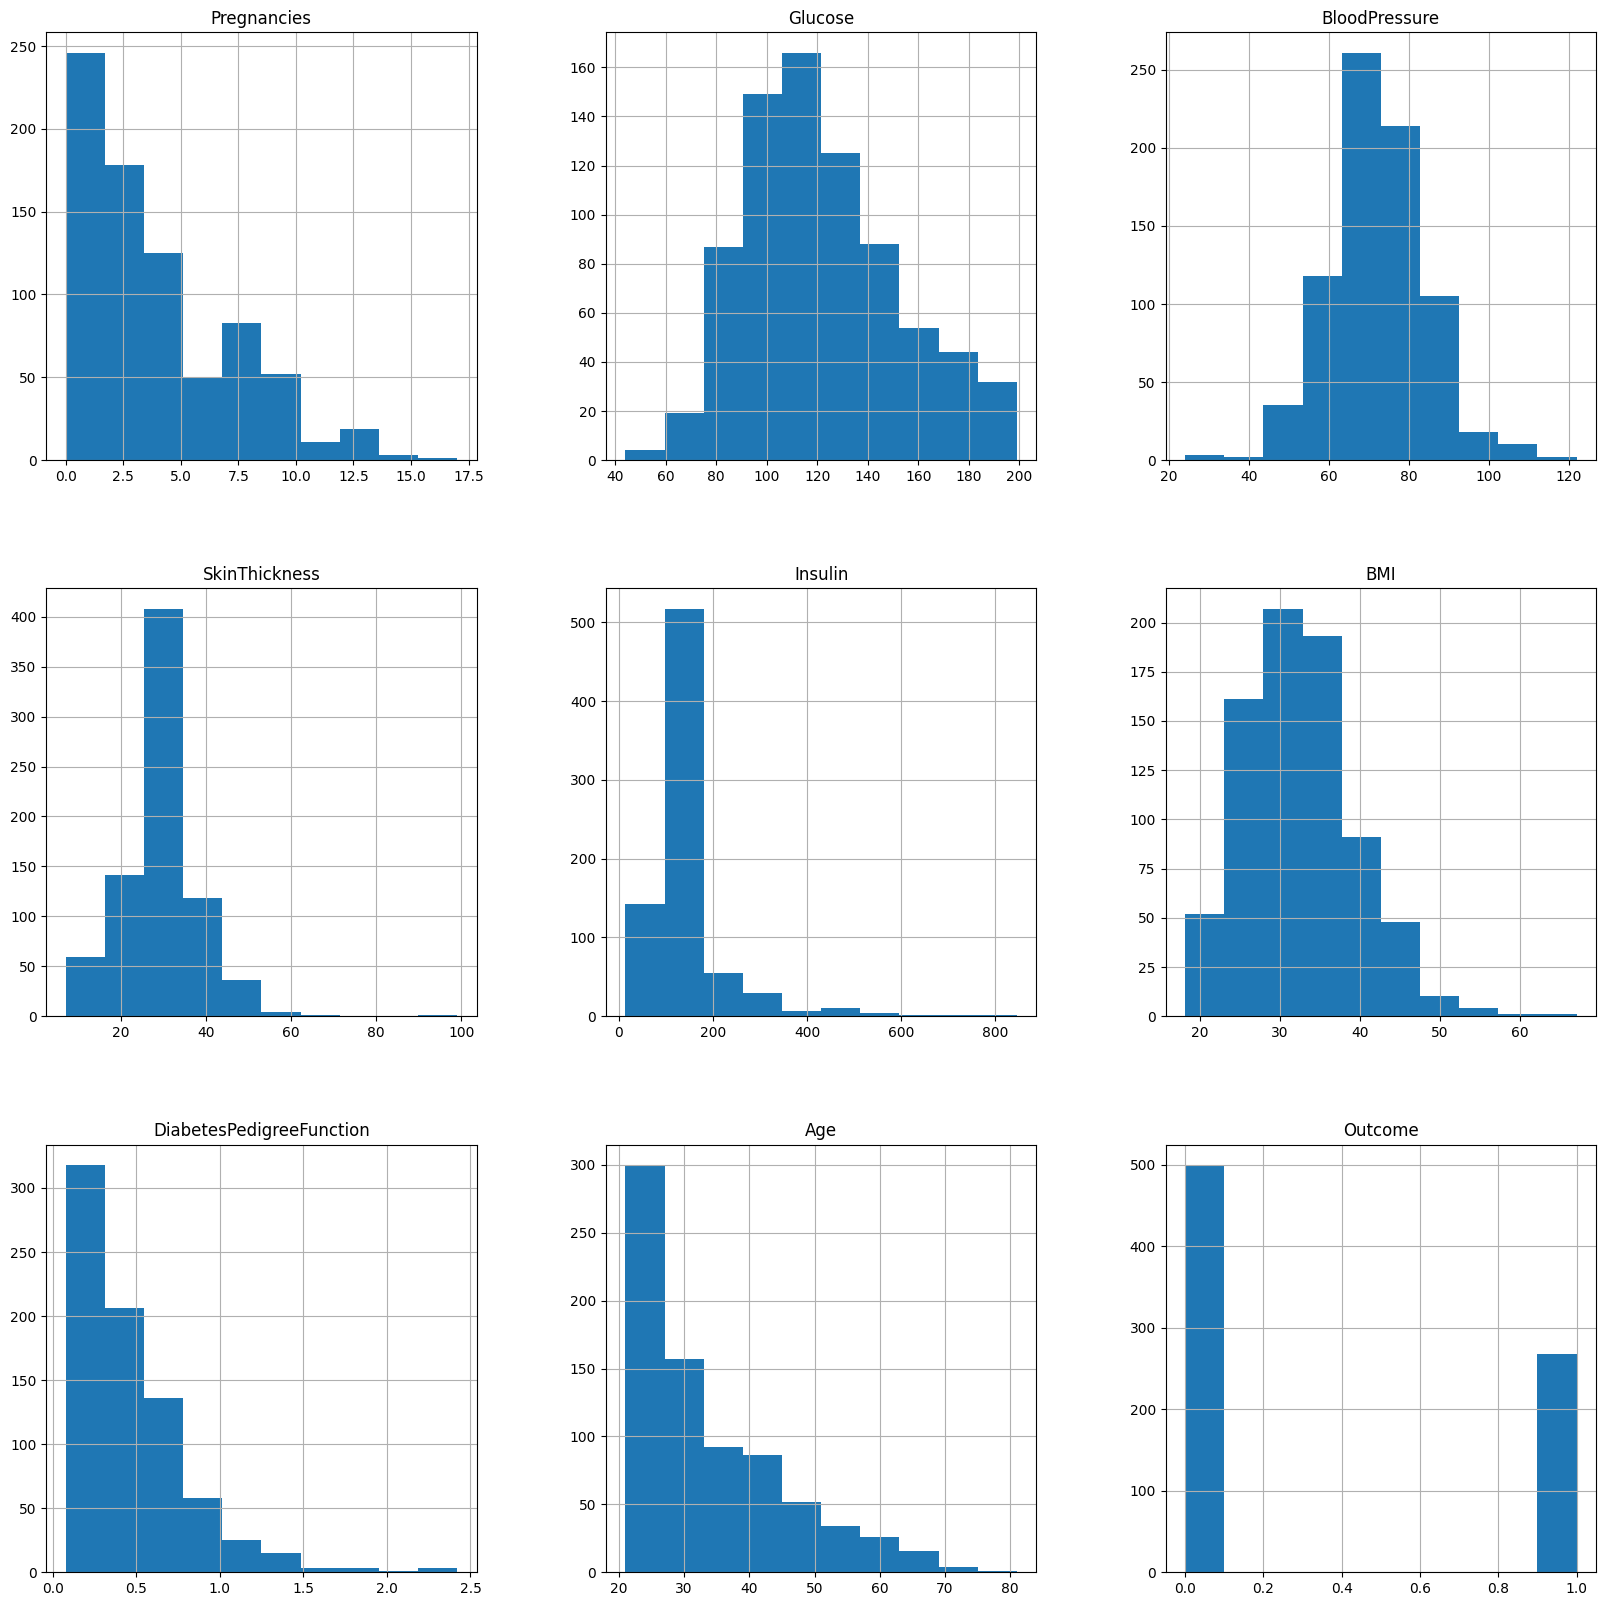

In [15]:
p = df.hist(figsize = (20,20))
p

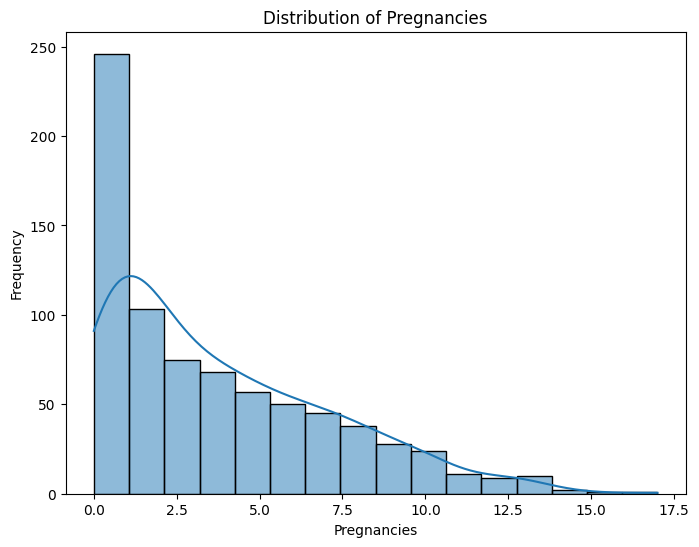

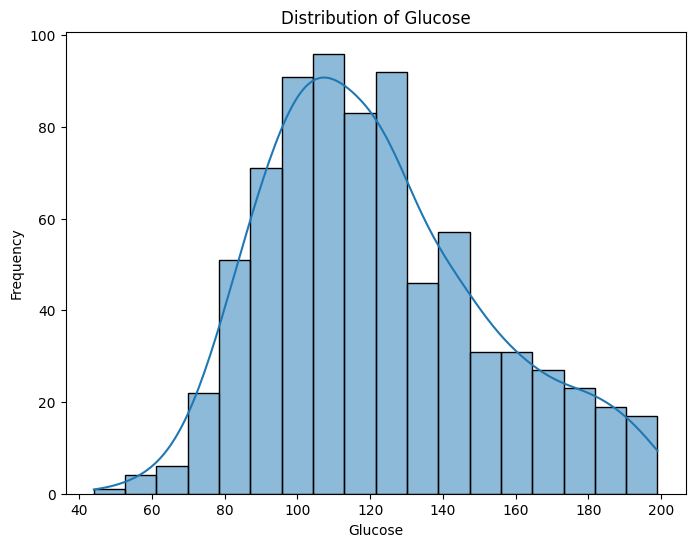

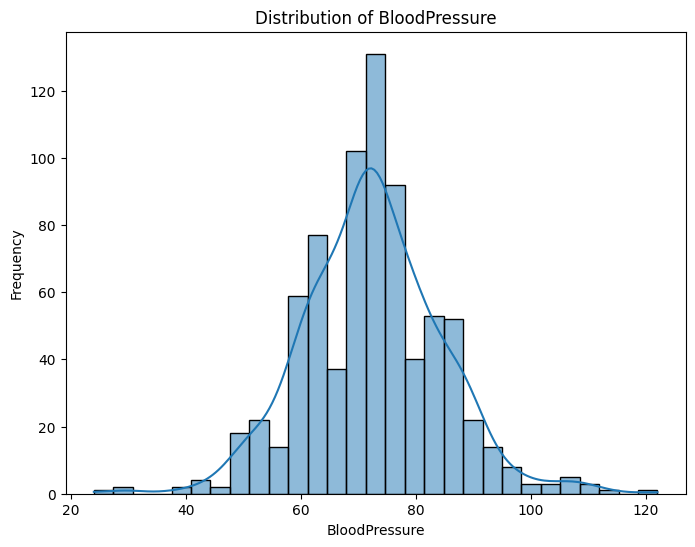

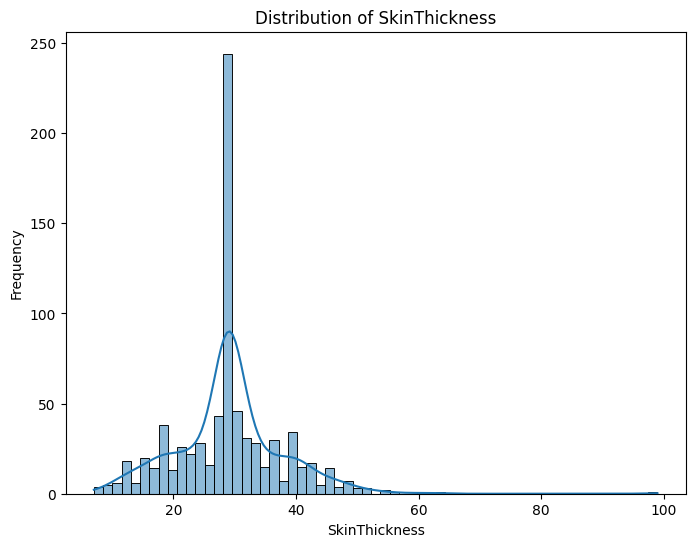

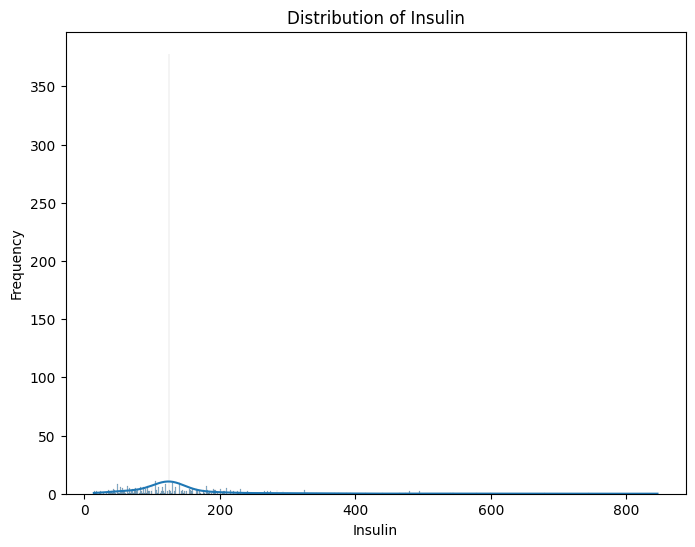

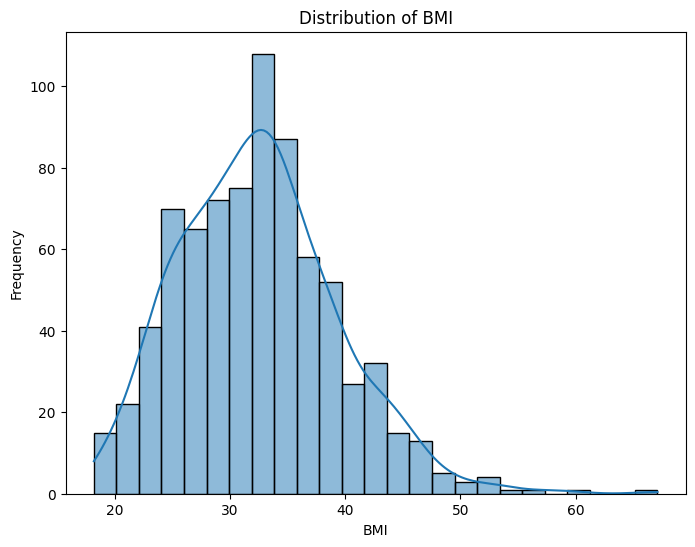

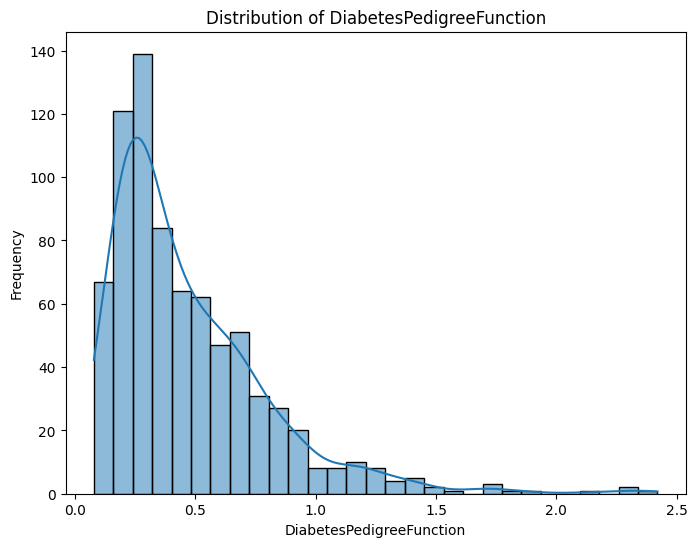

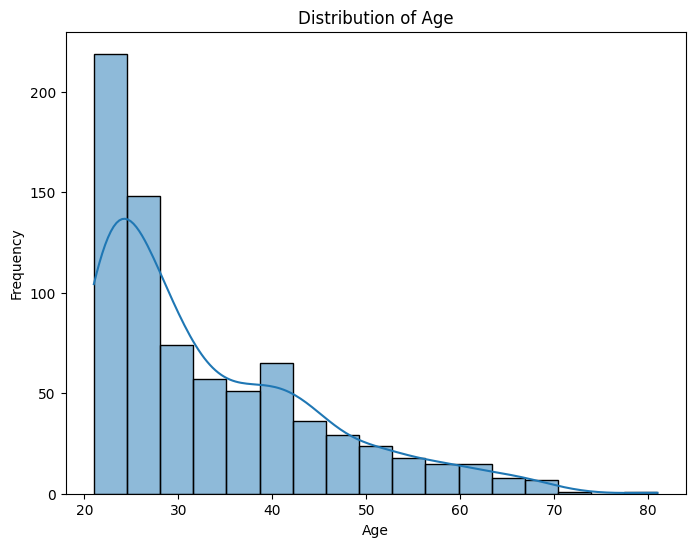

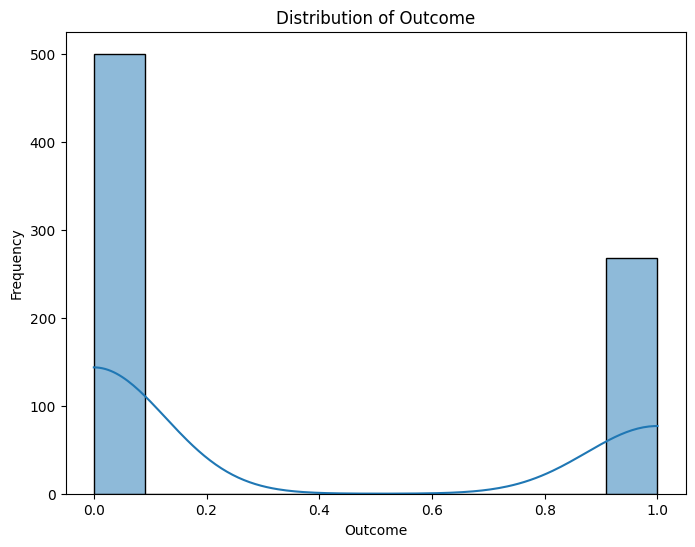

In [16]:
for col in df.columns:
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    sns.histplot(df[col], kde=True)  # Create the histplot with KDE
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [17]:
columns_to_check = ['Insulin', 'SkinThickness', 'DiabetesPedigreeFunction']

# Hàm tính toán các cận dưới và cận trên của IQR
def calculate_outlier_bounds(df, column_name):
    # Tính Q1 và Q3
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR  # Cận dưới
    upper_bound = Q3 + 1.5 * IQR  # Cận trên
    return lower_bound, upper_bound

# Hàm thay thế ngoại lệ bằng giá trị cận dưới/cận trên
def replace_outliers_with_bounds(df, column_name, lower_bound, upper_bound):
    df[column_name] = df[column_name].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))
    return df

# Áp dụng xử lý ngoại lệ cho các cột cần kiểm tra
for column in columns_to_check:
    lower_bound, upper_bound = calculate_outlier_bounds(df, column)
    df = replace_outliers_with_bounds(df, column, lower_bound, upper_bound)


* Phương pháp cắt giới hạn (Clipping):
Trong đoạn mã, chúng ta thay thế các giá trị ngoại lệ trong một cột của DataFrame bằng các giá trị cận dưới (lower bound) hoặc cận trên (upper bound) được tính từ IQR.
* Nếu giá trị nhỏ hơn cận dưới, nó sẽ được thay thế bằng cận dưới.
Nếu giá trị lớn hơn cận trên, nó sẽ được thay thế bằng cận trên.
Nếu giá trị nằm trong khoảng giữa cận dưới và cận trên, giá trị không bị thay đổi

Tại sao sử dụng phương pháp này?
Giữ lại tính toàn vẹn của dữ liệu:

Cắt giới hạn (Clipping) giúp giữ lại các phần tử trong phạm vi hợp lý của dữ liệu mà không làm mất thông tin hoàn toàn.
Khi thay thế các ngoại lệ bằng giá trị cận dưới hoặc cận trên, bạn không làm mất đi các điểm dữ liệu có thể mang tính quan trọng, mà chỉ điều chỉnh chúng về mức giá trị hợp lý.
Giảm tác động của ngoại lệ:

Ngoại lệ có thể làm lệch các thống kê như mean hoặc variance, đặc biệt trong các mô hình học máy. Bằng cách thay thế ngoại lệ bằng các giá trị hợp lý (cận dưới hoặc cận trên), bạn có thể giảm thiểu tác động tiêu cực của chúng mà không làm mất mát dữ liệu.
Giảm thiểu đa cộng tuyến:

Trong các mô hình học máy, ngoại lệ có thể gây ra vấn đề đa cộng tuyến (multicollinearity), đặc biệt là khi các biến có mối tương quan cao. Bằng cách thay thế các ngoại lệ, bạn giảm thiểu khả năng này.
Dễ hiểu và đơn giản:

Phương pháp thay thế ngoại lệ bằng cận dưới và cận trên đơn giản và dễ triển khai. Đây là một trong những cách phổ biến và hiệu quả để xử lý ngoại lệ mà không làm mất đi quá nhiều dữ liệu quan trọng.
Đảm bảo tính hợp lý cho các mô hình học máy:

Các mô hình học máy như hồi quy tuyến tính hoặc các mô hình cây quyết định rất nhạy cảm với các giá trị ngoại lệ, có thể ảnh hưởng đến độ chính xác hoặc ổn định của mô hình. Thay thế ngoại lệ bằng các giá trị hợp lý giúp đảm bảo rằng các mô hình này có thể học từ dữ liệu một cách hiệu quả hơn.

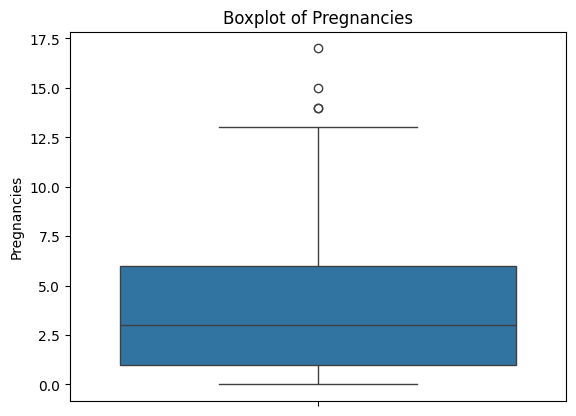

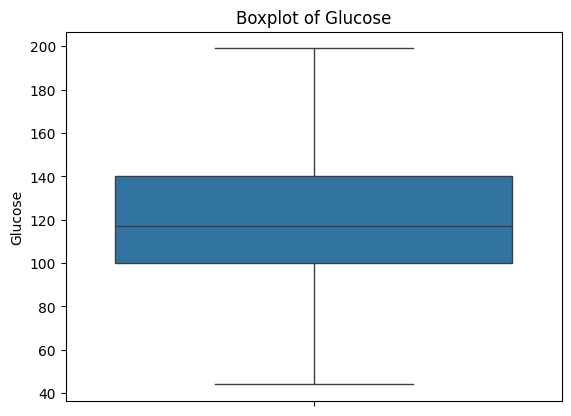

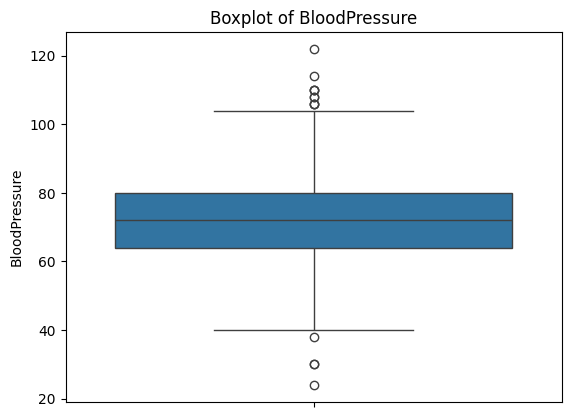

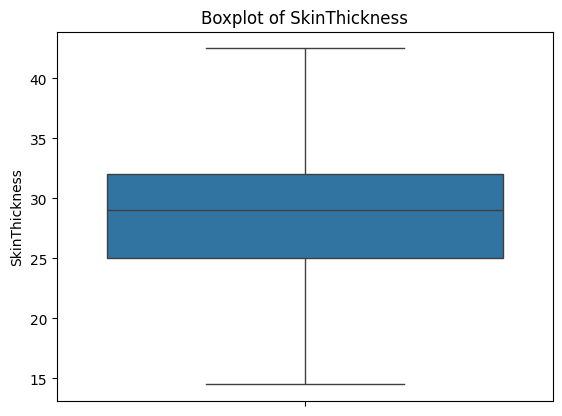

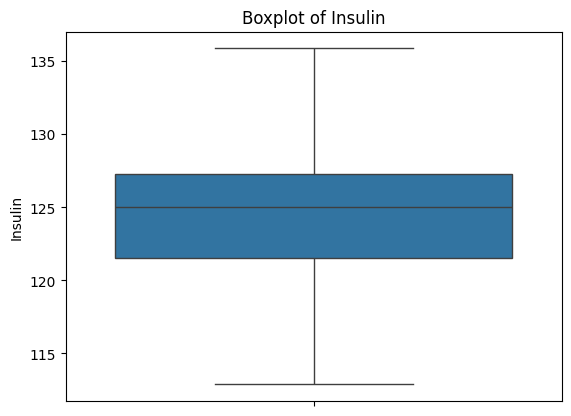

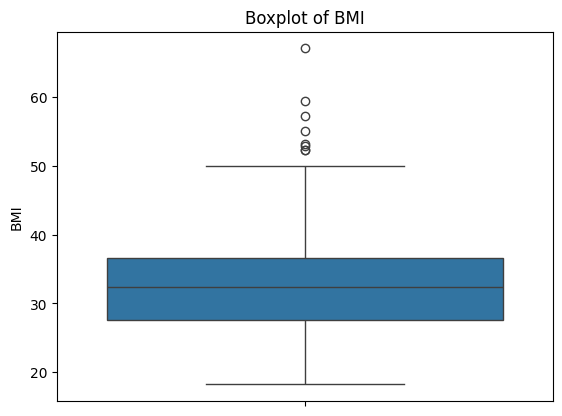

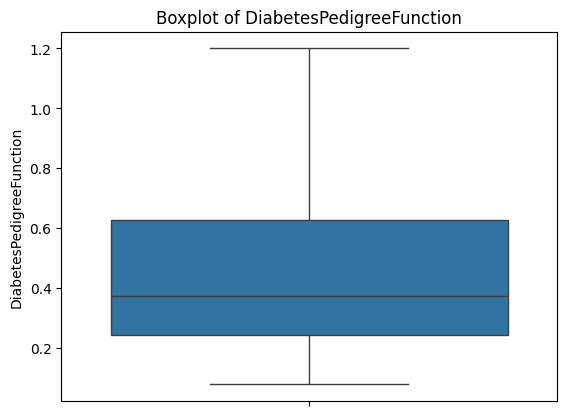

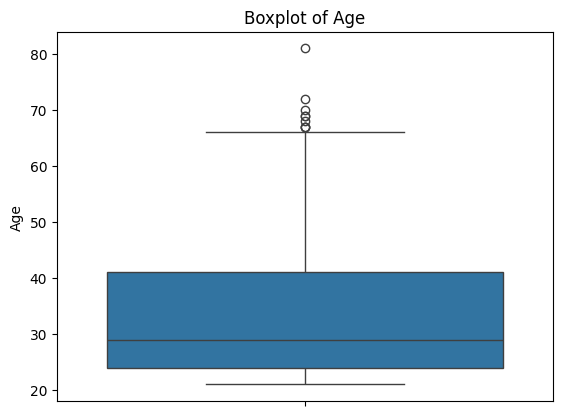

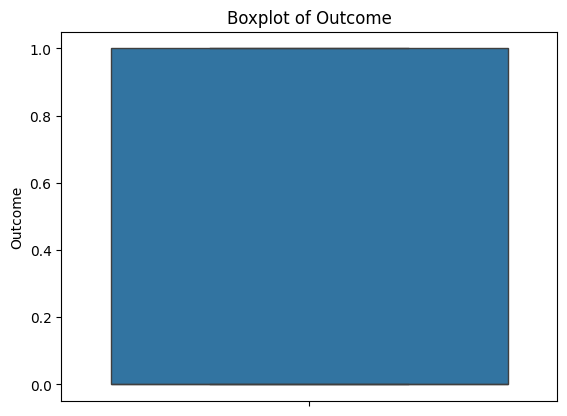

In [18]:
for col in df.columns:
    sns.boxplot(df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [19]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.656250      72.386719      28.866536  124.691081   
std       3.369578   30.438286      12.096642       7.442353    7.913595   
min       0.000000   44.000000      24.000000      14.500000  112.875000   
25%       1.000000   99.750000      64.000000      25.000000  121.500000   
50%       3.000000  117.000000      72.000000      29.000000  125.000000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      42.500000  135.875000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.455208                  0.458914   33.240885    0.348958  
std      6.875177                  0.285596   11.760232    0.476951  
min     18.200000                  0.078000   21.000000    0.000000  
25%     27.500000                  0.243750   24.000000    0.000000  
50%     32.300000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  1.200000   81.000000    1.000000

array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

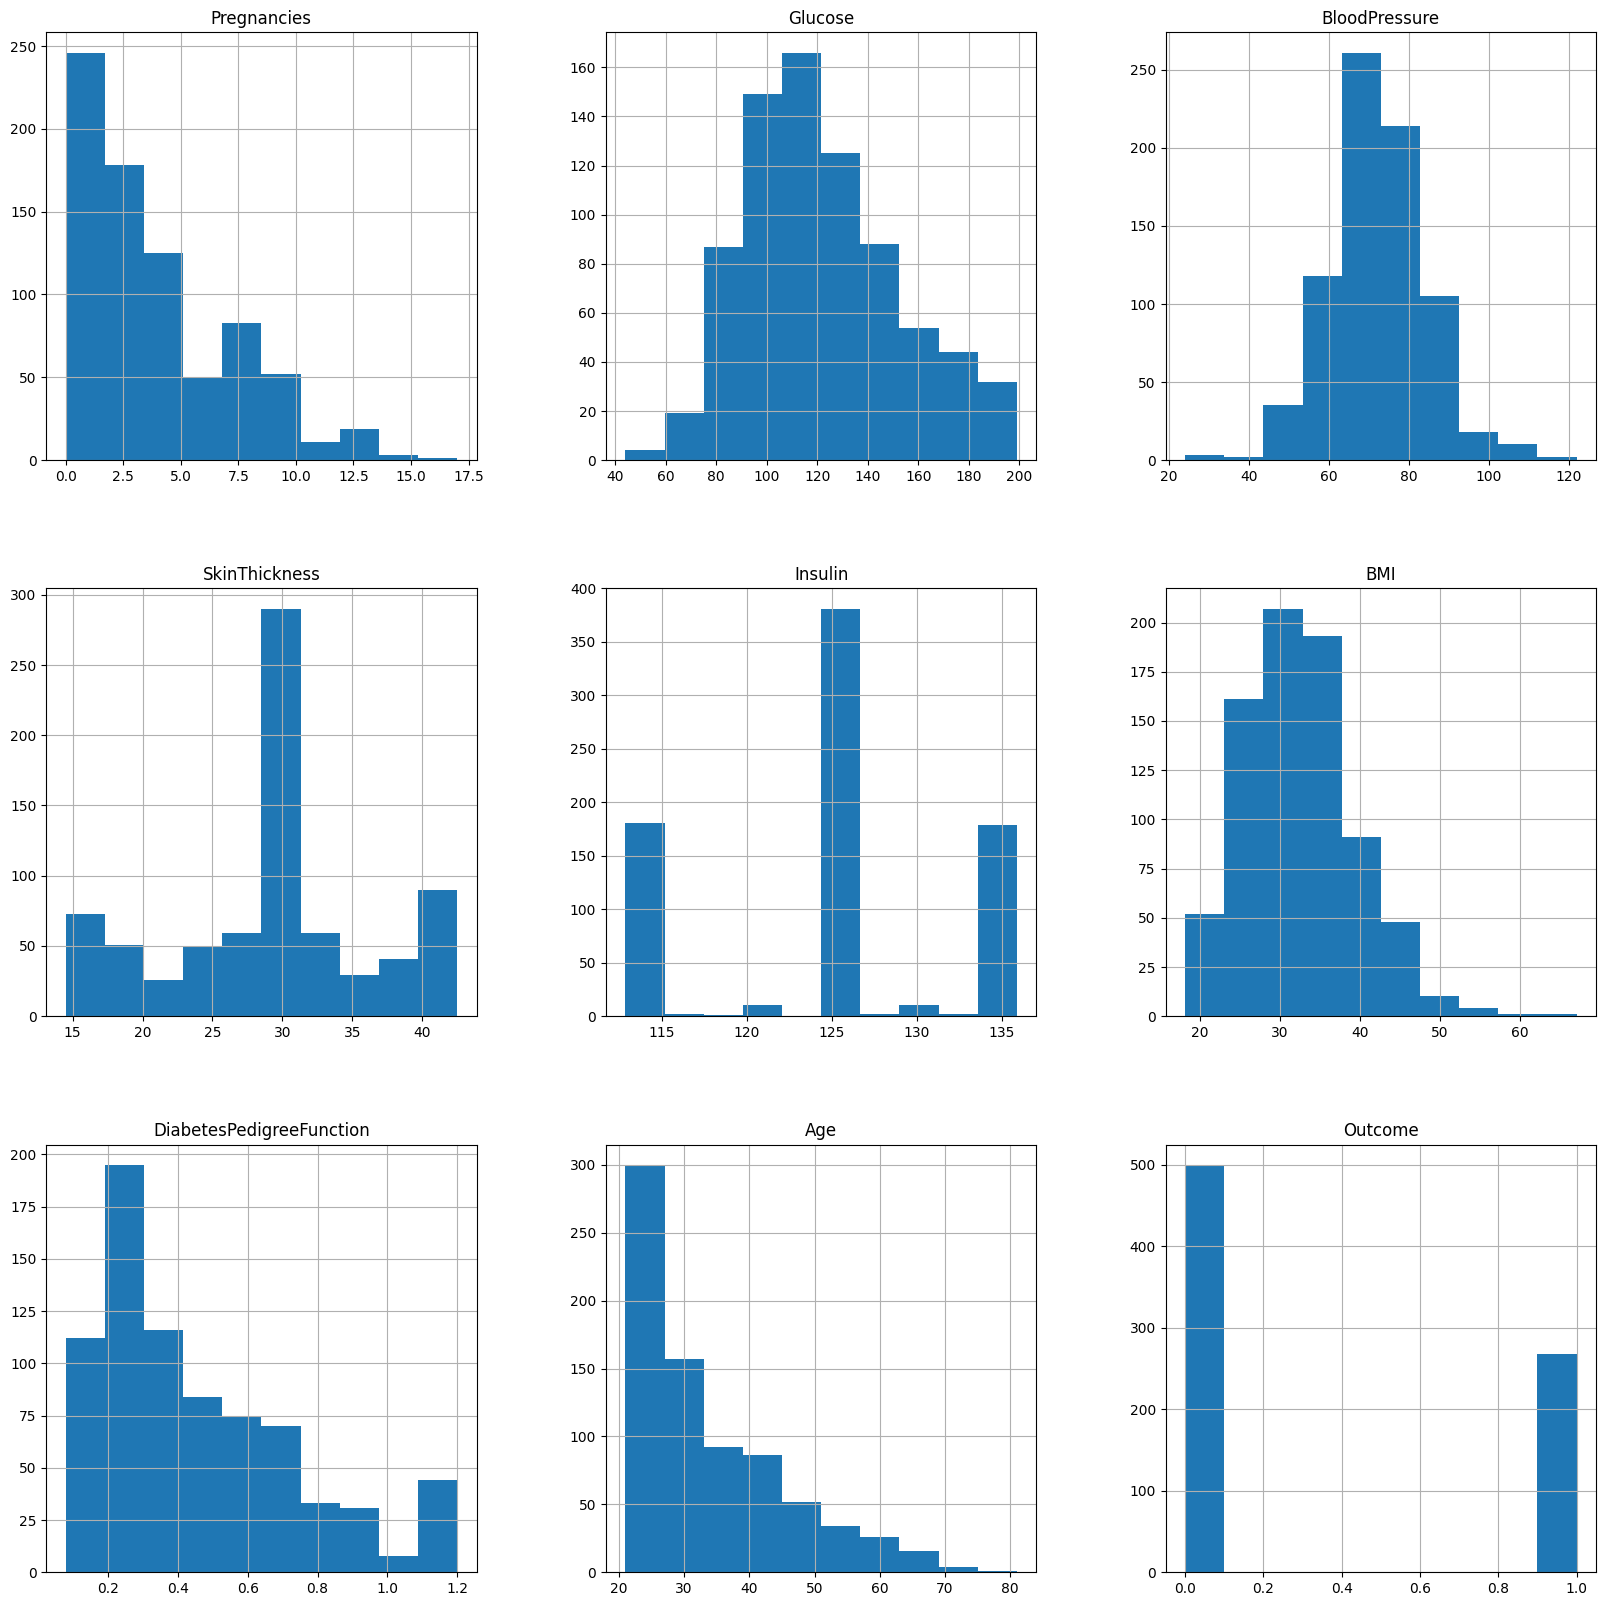

In [20]:
p = df.hist(figsize = (20,20))
p

## Ma trận tương quan

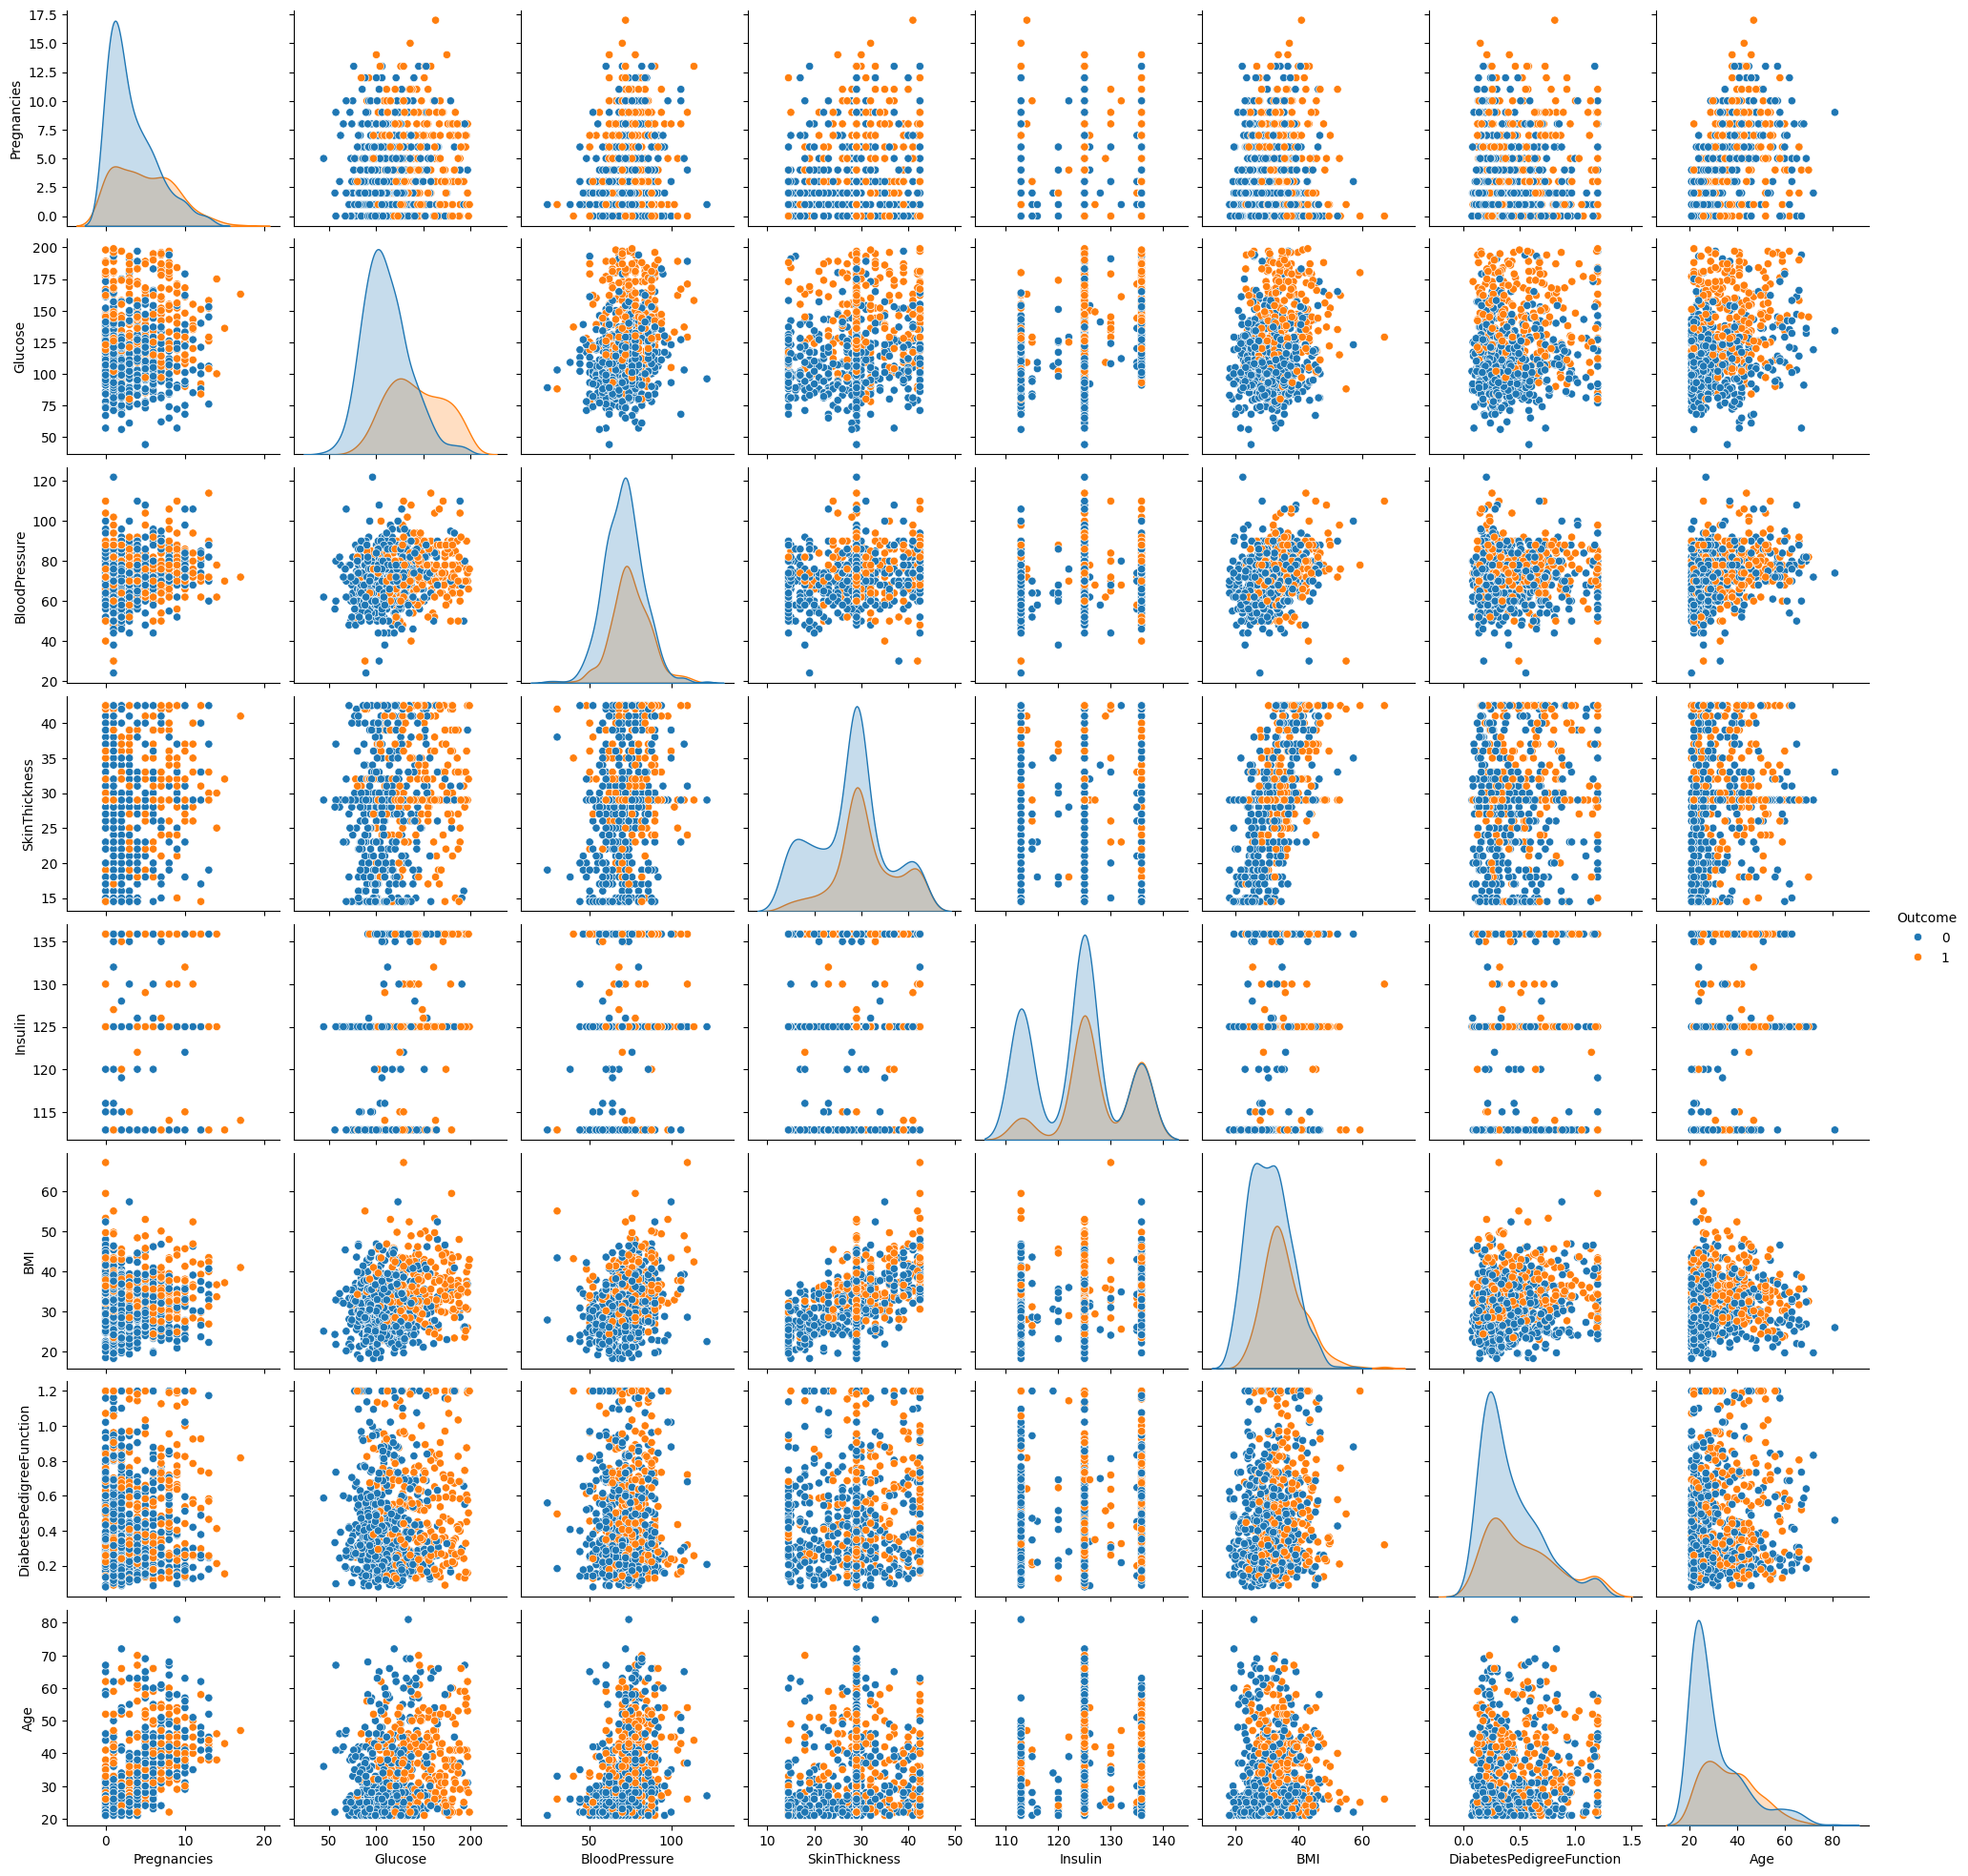

In [21]:
 p = sns.pairplot(df, hue="Outcome", diag_kind="kde")
p

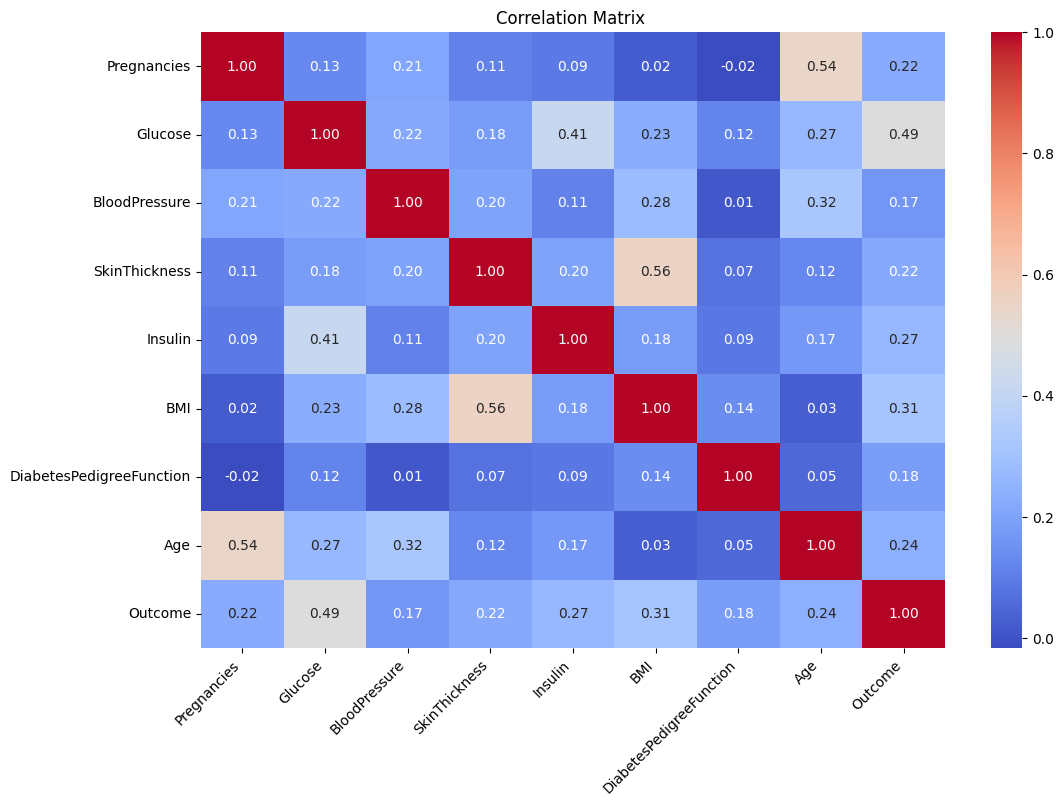

In [22]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix ')
plt.xticks(rotation=45, ha='right')
plt.show()


## Cân bằng dữ liệu

In [23]:
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [24]:
df_copy = df.copy()
df_copy.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72           35.0  125.000  33.6   
1            1       85             66           29.0  125.000  26.6   
2            8      183             64           29.0  125.000  23.3   
3            1       89             66           23.0  112.875  28.1   
4            0      137             40           35.0  135.875  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     1.200   33        1

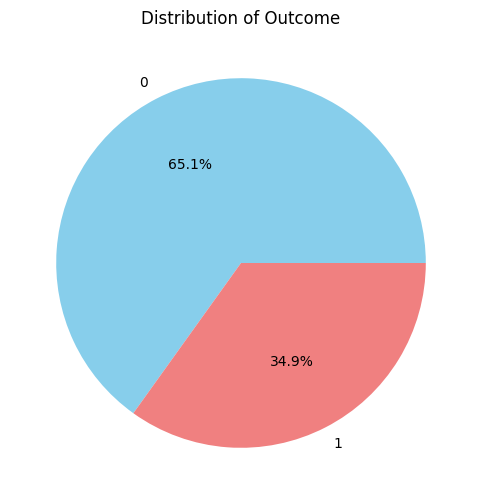

In [52]:
outcome_counts = df_copy['Outcome'].value_counts()

# Create the pie chart
plt.figure(figsize=(6, 6))  # Adjust figure size if needed
plt.pie(outcome_counts, labels=outcome_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Distribution of Outcome')
plt.show()

**Dữ liệu không cân bằng.**

Áp dụng phương pháp SMOTE để cân bằng dữ liệu. Vì:

Tăng số lượng mẫu của lớp thiểu số: SMOTE tạo ra các mẫu mới từ lớp thiểu số bằng cách nội suy giữa các điểm dữ liệu hiện có, giúp tăng số lượng mẫu mà không cần sao chép các mẫu hiện có. Điều này giúp mô hình học máy học tốt hơn từ cả hai lớp.

Giảm nguy cơ overfitting: So với phương pháp oversampling truyền thống (sao chép các mẫu hiện có), SMOTE giảm nguy cơ overfitting vì các mẫu mới được tạo ra từ sự kết hợp của các điểm dữ liệu hiện có, thay vì chỉ sao chép lại.

Bảo toàn thông tin: So với phương pháp undersampling (giảm số lượng mẫu của lớp chiếm ưu thế), SMOTE không làm mất thông tin quan trọng từ lớp chiếm ưu thế, giúp mô hình học máy có đủ dữ liệu để học.

Hiệu quả trong nhiều bài toán phân loại: SMOTE đã được chứng minh là hiệu quả trong nhiều bài toán phân loại khác nhau, đặc biệt là khi dữ liệu không cân bằng.

In [26]:

# Khởi tạo SMOTE
smote = SMOTE()

X = df_copy.drop(columns=['Outcome'])
y = df_copy['Outcome']
# Áp dụng SMOTE để tạo ra các mẫu mới cho lớp thiểu số
X_resampled, y_resampled = smote.fit_resample(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Outcome
1    500
0    500
Name: count, dtype: int64


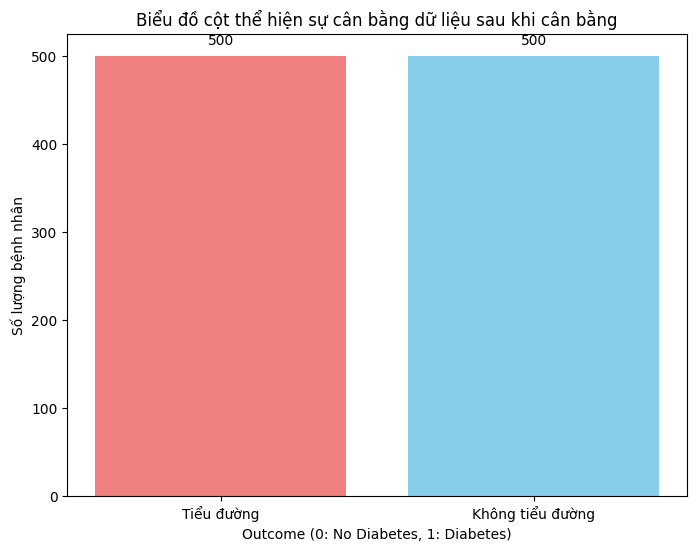

In [27]:
resampled_outcome_counts = pd.Series(y_resampled).value_counts()
print(resampled_outcome_counts)

# Vẽ biểu đồ cột sau khi cân bằng
plt.figure(figsize=(8, 6))
plt.bar(resampled_outcome_counts.index, resampled_outcome_counts.values, color=['skyblue', 'lightcoral'])
plt.xlabel("Outcome (0: No Diabetes, 1: Diabetes)")
plt.ylabel("Số lượng bệnh nhân")
plt.title("Biểu đồ cột thể hiện sự cân bằng dữ liệu sau khi cân bằng")
plt.xticks(resampled_outcome_counts.index, ['Không tiểu đường', 'Tiểu đường'])
for i, count in enumerate(resampled_outcome_counts.values):
    plt.text(i, count + 10, str(count), ha='center', va='bottom')
plt.show()

## HUẤN LUYỆN MÔ HÌNH

In [53]:
X_resampled.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72           35.0  125.000  33.6   
1            1       85             66           29.0  125.000  26.6   
2            8      183             64           29.0  125.000  23.3   
3            1       89             66           23.0  112.875  28.1   
4            0      137             40           35.0  135.875  43.1   

   DiabetesPedigreeFunction  Age  
0                     0.627   50  
1                     0.351   31  
2                     0.672   32  
3                     0.167   21  
4                     1.200   33

In [54]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
print("Kích thước tập train:", X_train.shape)
print("Kích thước tập test:", X_test.shape)

Kích thước tập train: (700, 8)
Kích thước tập test: (300, 8)


In [55]:
# Chuẩn hóa dữ liệu bằng StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [56]:

# Hàm tính toán các chỉ số
def print_metrics(model_name, y_true, y_pred, y_prob=None):
    print(f"\n{model_name}:")
    print(f"  Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"  Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"  Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"  F1-Score: {f1_score(y_true, y_pred):.4f}")

    if y_prob is not None:
        print(f"  AUC-ROC: {roc_auc_score(y_true, y_prob):.4f}")

    # Confusion Matrix
    print(f"  Confusion Matrix:\n{confusion_matrix(y_true, y_pred)}\n")


### Mô hình Logistic Regression

In [57]:
# Khởi tạo mô hình
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [58]:
logreg_predictions = logreg_model.predict(X_test)
logreg_prob = logreg_model.predict_proba(X_test)[:, 1]#Dự đoán xác suất cho AUC-ROC


In [59]:
print_metrics("Logistic Regression", y_test, logreg_predictions, logreg_prob)


Logistic Regression:
  Accuracy: 0.7700
  Precision: 0.7770
  Recall: 0.7616
  F1-Score: 0.7692
  AUC-ROC: 0.8456
  Confusion Matrix:
[[116  33]
 [ 36 115]]



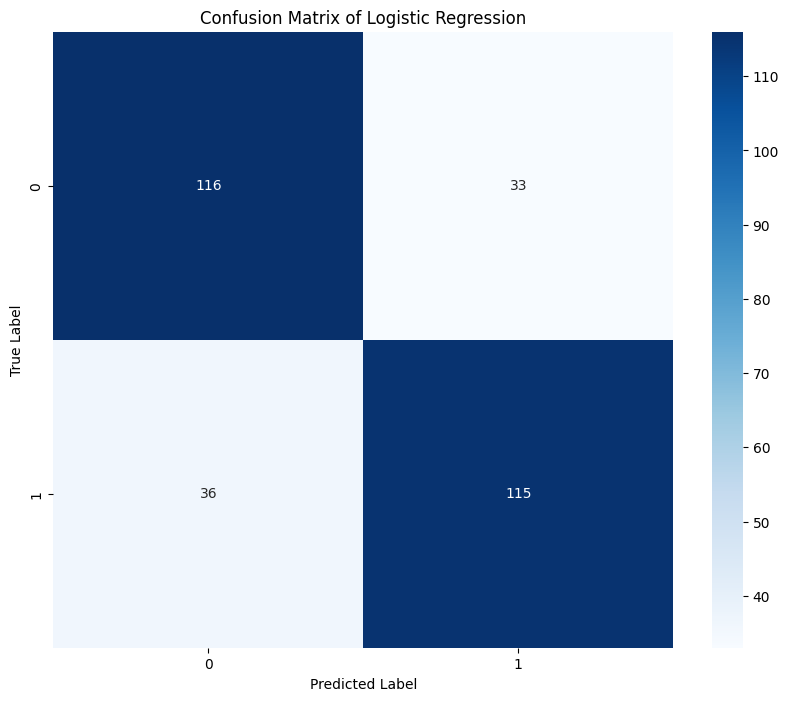

In [60]:
cm = confusion_matrix(y_test, logreg_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix of Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Nhận xét về Tập Test:
Dựa vào các ma trận nhầm lẫn, thì tính toán được thực tế có:
* 151 Giá trị "1"
* 149 Giá trị "0"

### SVM

In [78]:
# svm_model = SVC(kernel='rbf', C=5.0, gamma='scale',random_state=42, probability=True)
svm_model = SVC(random_state=42, probability=True)
svm_model.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [79]:
svm_predictions = svm_model.predict(X_test)
svm_prob = svm_model.predict_proba(X_test)[:, 1]  # Lấy xác suất cho lớp 1

In [80]:
print_metrics("SVM", y_test, svm_predictions, svm_prob)



SVM:
  Accuracy: 0.7433
  Precision: 0.7534
  Recall: 0.7285
  F1-Score: 0.7407
  AUC-ROC: 0.8288
  Confusion Matrix:
[[113  36]
 [ 41 110]]



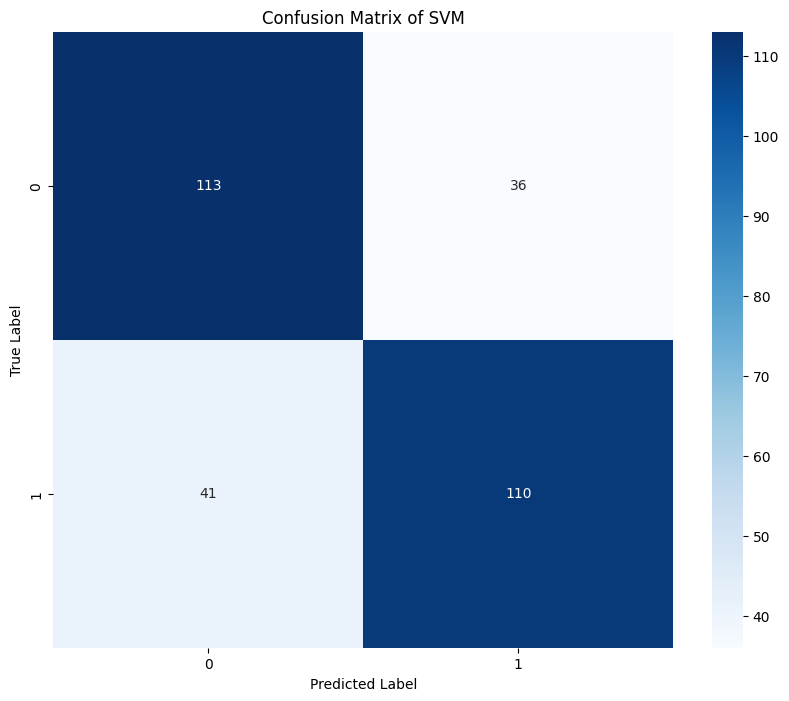

In [81]:
cm = confusion_matrix(y_test, svm_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix of SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Decision Tree

Decision tree không
cần chuẩn hóa, nên mình chia lại X và y

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


In [64]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [65]:
dt_predictions = dt_model.predict(X_test)
dt_prob = dt_model.predict_proba(X_test)[:, 1]  # Lấy xác suất cho lớp 1
print_metrics("Decision Tree", y_test, dt_predictions, dt_prob)



Decision Tree:
  Accuracy: 0.7200
  Precision: 0.7219
  Recall: 0.7219
  F1-Score: 0.7219
  AUC-ROC: 0.7200
  Confusion Matrix:
[[107  42]
 [ 42 109]]



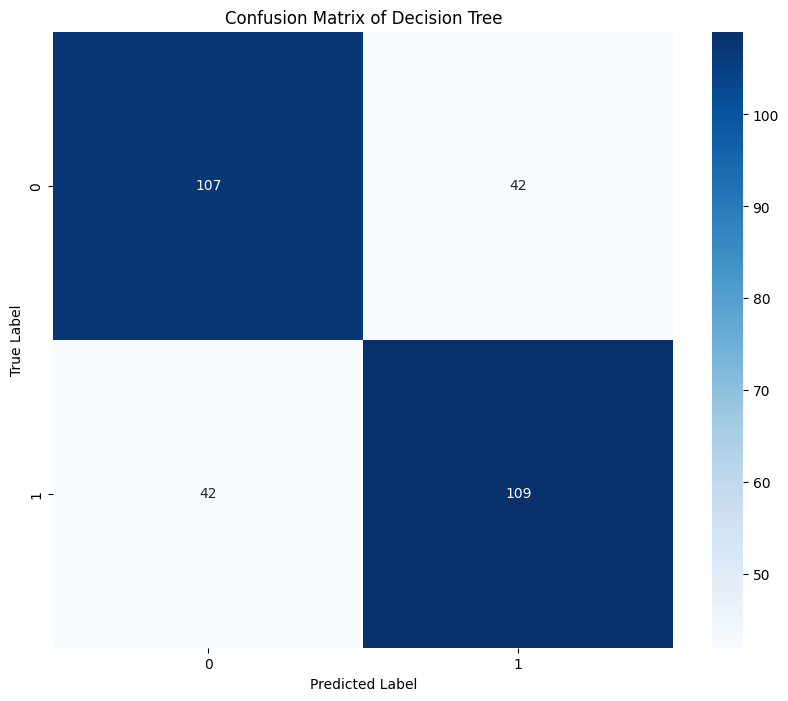

In [66]:
cm = confusion_matrix(y_test, dt_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix of Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [69]:
param_grid = {
    'max_depth': [5, 10, 15, 20, 25],  # Các giá trị cho max_depth
    'min_samples_split': [2, 4, 6, 8, 10],  # Các giá trị cho min_samples_split
    'min_samples_leaf': [1, 2, 5, 10, 20]  # Các giá trị cho min_samples_leaf
}

# Tạo mô hình DecisionTreeClassifier
model = DecisionTreeClassifier()

# Tạo GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

grid_search.fit(np.zeros((10, 5)), np.zeros(10))  # Không quan trọng dữ liệu, chỉ để thử các tham số

# In ra kết quả
print("Best Parameters found: ", grid_search.best_params_)

Fitting 3 folds for each of 125 candidates, totalling 375 fits
Best Parameters found:  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}



Tuned Decision Tree:
  Accuracy: 0.7467
  Precision: 0.7301
  Recall: 0.7881
  F1-Score: 0.7580
  AUC-ROC: 0.7921
  Confusion Matrix:
[[105  44]
 [ 32 119]]



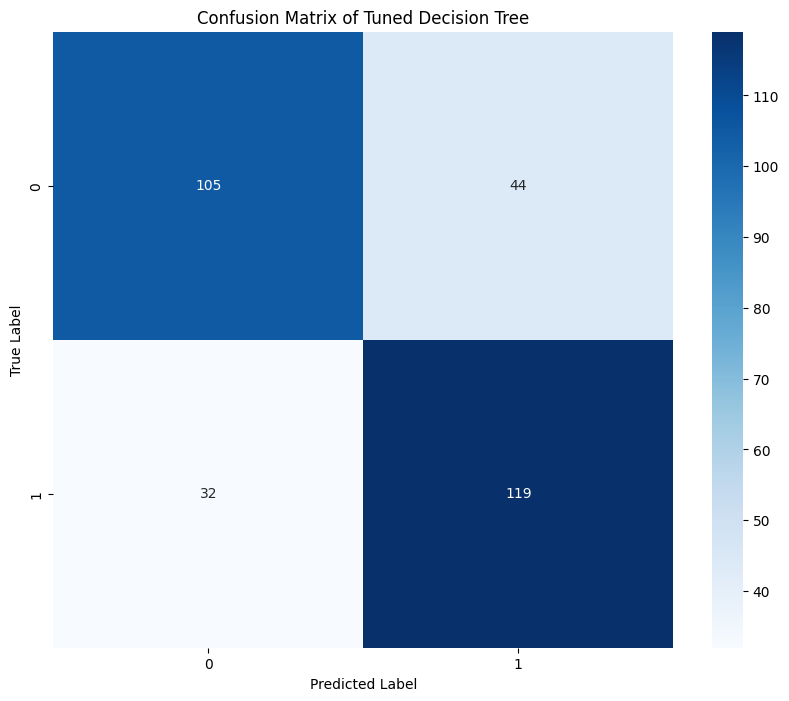

In [70]:
# Initialize and train the Decision Tree model with specified hyperparameters
dt_model_tuned = DecisionTreeClassifier(max_depth=5, min_samples_leaf=1, min_samples_split=2, random_state=42)
dt_model_tuned.fit(X_train, y_train)

# Make predictions on the test set
dt_predictions_tuned = dt_model_tuned.predict(X_test)
dt_prob_tuned = dt_model_tuned.predict_proba(X_test)[:, 1]

# Evaluate the tuned model
print_metrics("Tuned Decision Tree", y_test, dt_predictions_tuned, dt_prob_tuned)

# Confusion matrix for the tuned model
cm_tuned = confusion_matrix(y_test, dt_predictions_tuned)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_tuned, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix of Tuned Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [71]:
from sklearn.tree import export_text

# Assuming dt_model_tuned is your trained and tuned Decision Tree model
tree_rules = export_text(dt_model_tuned, feature_names=list(X.columns))
print(tree_rules)

|--- Glucose <= 127.50
|   |--- Age <= 28.50
|   |   |--- BMI <= 30.93
|   |   |   |--- DiabetesPedigreeFunction <= 0.67
|   |   |   |   |--- class: 0
|   |   |   |--- DiabetesPedigreeFunction >  0.67
|   |   |   |   |--- DiabetesPedigreeFunction <= 0.72
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- DiabetesPedigreeFunction >  0.72
|   |   |   |   |   |--- class: 0
|   |   |--- BMI >  30.93
|   |   |   |--- BMI <= 31.59
|   |   |   |   |--- Age <= 23.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Age >  23.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- BMI >  31.59
|   |   |   |   |--- DiabetesPedigreeFunction <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- DiabetesPedigreeFunction >  0.50
|   |   |   |   |   |--- class: 0
|   |--- Age >  28.50
|   |   |--- BMI <= 26.95
|   |   |   |--- Age <= 29.50
|   |   |   |   |--- class: 1
|   |   |   |--- Age >  29.50
|   |   |   |   |--- class: 0
|   |   |--- BMI >  26.95
|   |   |   |--- Glucose <= 94.

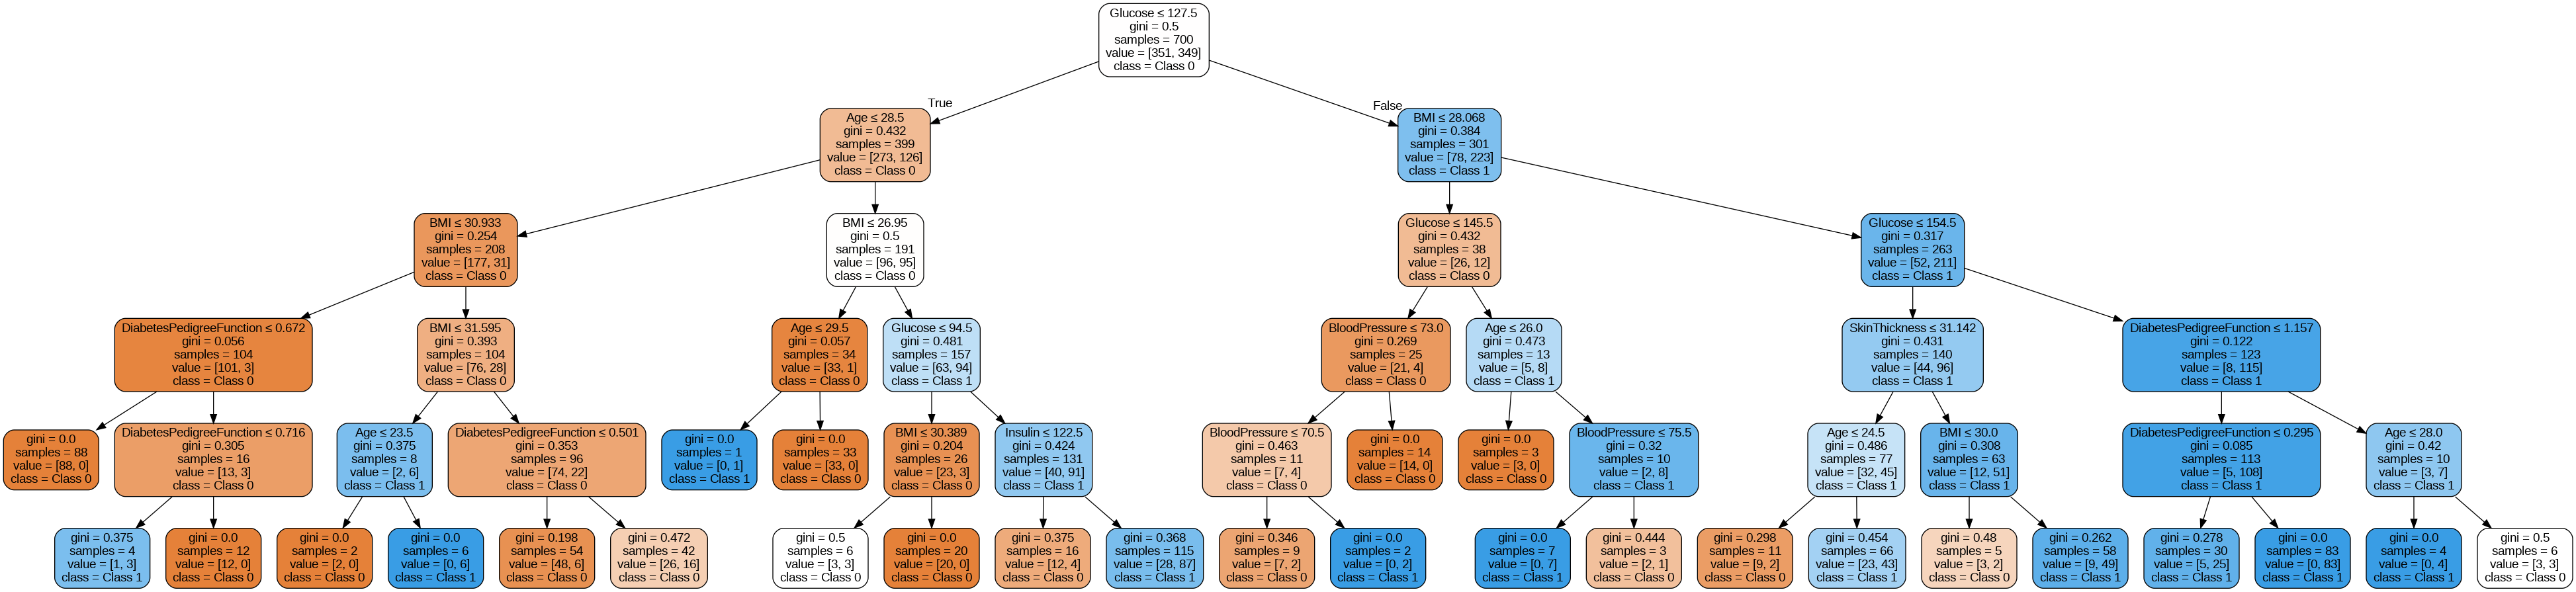

Cây quyết định đã được lưu tại: /content/drive/MyDrive/Colab Notebooks/data ML/Final/decision_tree copy(b3).png


In [72]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from graphviz import Source
from google.colab import drive
from IPython.display import display, Image

# Tạo tệp .dot chứa cây quyết định
dot_data = export_graphviz(dt_model_tuned, out_file=None,
                           feature_names=X.columns,  # Các cột đặc trưng
                           class_names=['Class 0', 'Class 1'],  # Thay đổi tên lớp nếu cần
                           filled=True, rounded=True,
                           special_characters=True)

# Sử dụng graphviz để hiển thị cây quyết định
graph = Source(dot_data)

# Hiển thị cây quyết định dưới dạng PNG trong Colab
display(Image(graph.pipe(format='png')))

# Lưu cây quyết định dưới dạng tệp PNG vào Google Drive
output_path = '/content/drive/MyDrive/Colab Notebooks/data ML/Final/decision_tree copy(b3).png'  # Đường dẫn lưu trong Google Drive
graph.render(output_path, format='png')

print(f"Cây quyết định đã được lưu tại: {output_path}")

### Linear Regression

Linear regression thường được sử dụng để dự đoán các giá trị liên tục, nhưng nó cũng có thể được áp dụng trong các bài toán phân loại, ví dụ như dự đoán giá trị 0 hoặc 1. Nên tôi sẽ thử huấn luyện với mô hình Linear Regression.

In [73]:
linearreg_model = LinearRegression()
linearreg_model.fit(X_train, y_train)


LinearRegression()

In [74]:
linearreg_predictions = linearreg_model.predict(X_test)

In [75]:
# Redefine the print_metrics function to handle regression metrics
def print_metr(model_name, y_true, y_pred, y_prob=None):
    print(f"\n{model_name}:")
    # Replace classification metrics with regression metrics
    print(f"  Mean Squared Error: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"  R-squared: {r2_score(y_true, y_pred):.4f}")

# Apply the function using regression predictions from the LinearRegression model
print_metr("Linear Regression", y_test, linearreg_predictions)  # Call print_metrics with regression model predictions


Linear Regression:
  Mean Squared Error: 0.1620
  R-squared: 0.3520


## New data, dự đoán

In [82]:
import pandas as pd

# Dữ liệu mới cần dự đoán
new_data = {
    'Pregnancies': [3],
    'Glucose': [120],
    'BloodPressure': [70],
    'SkinThickness': [30],
    'Insulin': [150],
    'BMI': [37.5],
    'DiabetesPedigreeFunction': [0.450],
    'Age': [30]
}

# Chuyển dữ liệu mới thành DataFrame
new_data_df = pd.DataFrame(new_data)
# Dự đoán với Logistic Regression
logreg_pred = logreg_model.predict(new_data_df)
# Dự đoán với SVM
svm_pred = svm_model.predict(new_data_df)
# Dự đoán với Linear Regression
linreg_pred = linearreg_model.predict(new_data_df)

# Hiển thị kết quả dự đoán
print(f"Dự đoán với Logistic Regression: {logreg_pred}")
print(f"Dự đoán với SVM: {svm_pred}")
print(f"Dự đoán với Linear Regression: {linreg_pred}")
# Dự đoán với Decision Tree
dt_pred = dt_model_tuned.predict(new_data_df)
print(f"Dự đoán với Decision Tree: {dt_pred}")

Dự đoán với Logistic Regression: [1]
Dự đoán với SVM: [1]
Dự đoán với Linear Regression: [0.54851391]
Dự đoán với Decision Tree: [1]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Dự đoán với Linear Regression có giá trị > 0.5 => Dự đoán là 1